In [67]:
import pandas as pd, numpy as np
import argparse
import pickle
import ast
import pandas as pd

In [163]:
with open("ddi_0_30_0_30_gpt-4o-2024-05-13_50.pkl", "rb") as f:
    raw_pickle = pickle.load(f)

In [164]:
for k,v in raw_pickle.items():
    print(len(v[2]))

110
110
64


TypeError: object of type 'int' has no len()

In [69]:
def pickle_to_res(path):
    with open(path, "rb") as f:
        raw_pickle = pickle.load(f)

    results = {}
    answer_prefix="Answer Choice "

    def extract_ans(ans_str, search_substring):
        # Split the string into lines
        lines = ans_str.split("\n")

        for line in lines:
            # Check if the line starts with the specified substring
            if line.startswith(search_substring):
                # If it does, add it to the list of extracted rows
                return line[len(search_substring) :].strip()
        return "ERROR"  # Answer not found

    for k, v in raw_pickle.items():
        if k != 'token_usage':  # Skip token_usage
            qns_idx = ast.literal_eval(k)
            for idx, qn_idx in enumerate(qns_idx):
                results[qn_idx] = extract_ans(
                    v[0], f"{answer_prefix}{idx+1}:"
                )  # We start with question 1
    
    return results

In [70]:
def res_to_vec(res):
    test_df = pd.read_csv('/home/joseph/biasICL/ddi_test_metadata.csv', index_col=0)
    num_errors = 0
    labels, preds, race = [], [], []
    for i in test_df.itertuples():
        fst = '12' if i.skin_tone == 12 else '56'
        if (i.Index not in results) or (results[i.Index].startswith("ERROR")):
            num_errors += 1

            print(i.Index, f"answer not found")
            continue

        pred_text = results[i.Index]
        ground_truth = "B" if i.malignant == True else "A"
        labels.append(ground_truth)
        preds.append(pred_text)
        race.append(fst)
        
    print(f"In total {num_errors} errors len = {len(labels)}")
    return labels,preds,race

In [133]:
def calculate_metrics(actual, predicted):
    TP = sum((a == 'B' and p == 'B') for a, p in zip(actual, predicted))
    TN = sum((a == 'A' and p == 'A') for a, p in zip(actual, predicted))
    FP = sum((a == 'A' and p == 'B') for a, p in zip(actual, predicted))
    FN = sum((a == 'B' and p == 'A') for a, p in zip(actual, predicted))
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    # Calculate F1 score
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0
    
    accuracy = (TP + TN) / len(actual)
    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
    tnr = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    return accuracy, tpr, tnr, f1_score



def filter_by_race(actual, predicted, race, race_value):
    filtered_actual = [a for a, r in zip(actual, race) if r == race_value]
    filtered_predicted = [p for p, r in zip(predicted, race) if r == race_value]
    return filtered_actual, filtered_predicted



In [152]:
exps = ["ddi_0_0_0_0_gpt-4o-2024-05-13_50.pkl",
"ddi_0_30_0_30_gpt-4o-2024-05-13_50.pkl",
"ddi_30_0_0_10_gpt-4o-2024-05-13_50.pkl",
"ddi_30_10_0_0_gpt-4o-2024-05-13_50.pkl",
"ddi_30_10_30_10_gpt-4o-2024-05-13_50.pkl"]

In [153]:
bulk_accs = []
bulk_tprs = []
bulk_fscores = []

fst12_accs = []
fst12_tprs = []
fst12_fscores = []

fst56_accs = []
fst56_tprs = []
fst56_fscores = []

for exp in exps:

    results = pickle_to_res(exp)
    labels,preds,race = res_to_vec(results)



    accuracy, tpr, tnr, fscore = calculate_metrics(labels, preds)
#     print(f"Accuracy: {accuracy}, TPR: {tpr}, TNR: {tnr}, F1: {fscore}")

    # Filter for race '12'
    actual_12, predicted_12 = filter_by_race(labels, preds, race, '12')
    accuracy_12, tpr_12, tnr_12, fscore_12 = calculate_metrics(actual_12, predicted_12)

    # Filter for race '56'
    actual_56, predicted_56 = filter_by_race(labels, preds, race, '56')
    accuracy_56, tpr_56, tnr_56, fscore_56 = calculate_metrics(actual_56, predicted_56)

#     # Output results
#     print(f"Race '12' - Accuracy: {accuracy_12}, TPR: {tpr_12}, TNR: {tnr_12}, F1: {fscore_12}")
#     print(f"Race '56' - Accuracy: {accuracy_56}, TPR: {tpr_56}, TNR: {tnr_56}, F1: {fscore_56}")

    bulk_accs.append(accuracy)
    bulk_tprs.append(tpr)
    bulk_fscores.append(fscore)
    
    fst12_accs.append(accuracy_12)
    fst12_tprs.append(tpr_12)
    fst12_fscores.append(fscore_12)
    
    fst56_accs.append(accuracy_56)
    fst56_tprs.append(tpr_56)
    fst56_fscores.append(fscore_56)

In total 0 errors len = 104
In total 0 errors len = 104
In total 0 errors len = 104
In total 0 errors len = 104
In total 0 errors len = 104


In [74]:
import matplotlib.pyplot as plt

In [159]:
def plot_experiment_metrics(bulk,fst12,fst56,score_type):
#     bulk_fscore = [0.4516, 0.56, 0.6274, 0.5, 0.4]
#     fst12_fscore = [0.4583,0.58, 0.47058, 0.41, 0.375]
#     fst56_fscore = [0.44444,0.54, 0.70588, 0.58, 0.4242]
    biases = np.array(fst12) - np.array(fst56)
    labels = ['0,0,0,0', '0,30,0,30', '30,0,0,10', '30,10,0,0', '30,10,30,10']
    
    # Plot 1: Grouped bar plot for bulk accuracy, FST 1/2 accuracy, and FST 5/6 accuracy
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    # Use custom colors for the bars
    bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    rects1 = ax1.bar(x - width, bulk, width, label=f'Aggregate {score_type}', color=bar_colors[0])
    rects2 = ax1.bar(x, fst12, width, label=f'FST 1/2 {score_type}', color=bar_colors[1])
    rects3 = ax1.bar(x + width, fst56, width, label=f'FST 5/6 {score_type}', color=bar_colors[2])

    # Add labels, title, and custom ticks
#     ax1.set_ylim([0.30,0.9])
    ax1.set_xlabel('Experiments (FST1/2 Benign, FST1/2 Malignant, FST5/6 Benign, FST5/6 Malignant)')
    ax1.set_ylabel(f'{score_type}')
    ax1.set_title(f'{score_type} by Experiment and Skin Type')

    # Set wrapped labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)  # Apply wrapped labels

    ax1.legend()
    
    # Plot 2: Bias plot
    fig, ax2 = plt.subplots(figsize=(10, 6))
    rects4 = ax2.bar(x, np.abs(biases), width, color='purple', label=f'Bias (FST 1/2 - FST 5/6 {score_type})')
    
    # Add labels, title, and custom ticks
    ax2.set_xlabel('Experiments')
    ax2.set_ylabel('Bias')
    ax2.set_title('Bias by Experiment')

    # Set wrapped labels for second plot
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)  # Apply wrapped labels
    
    ax2.legend()

    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

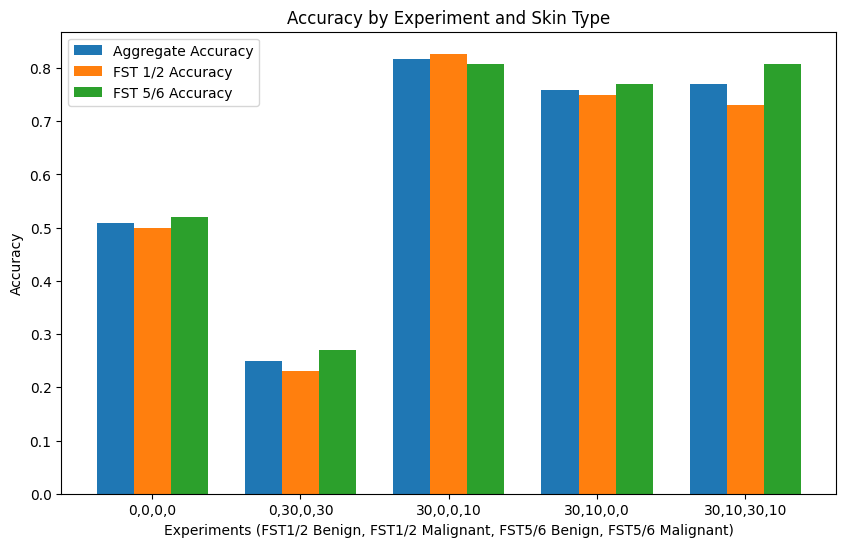

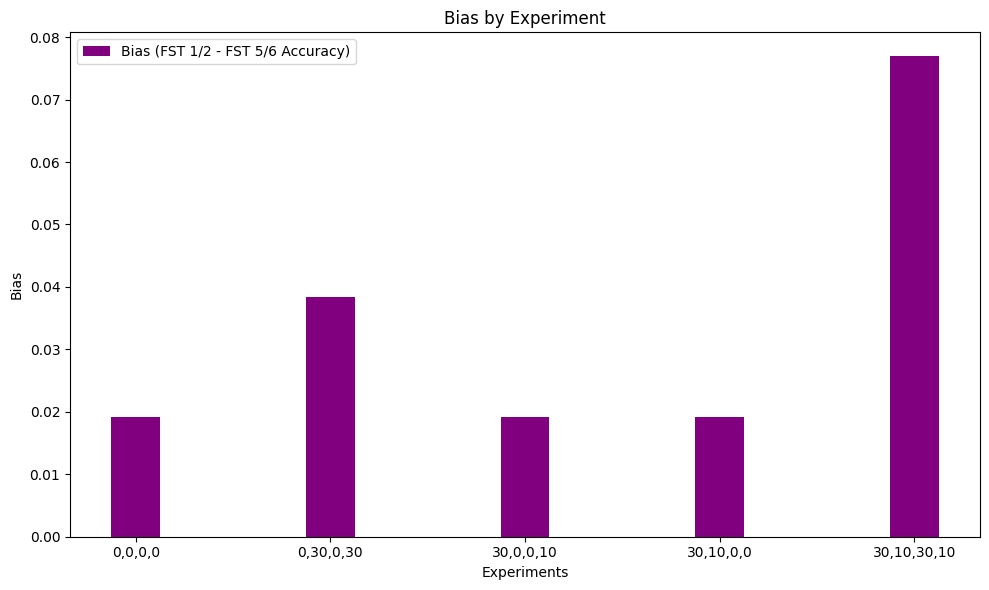

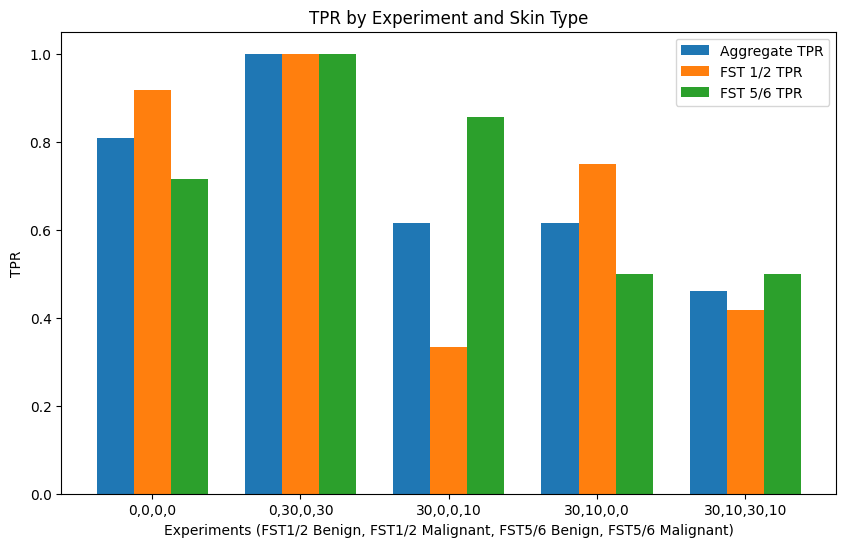

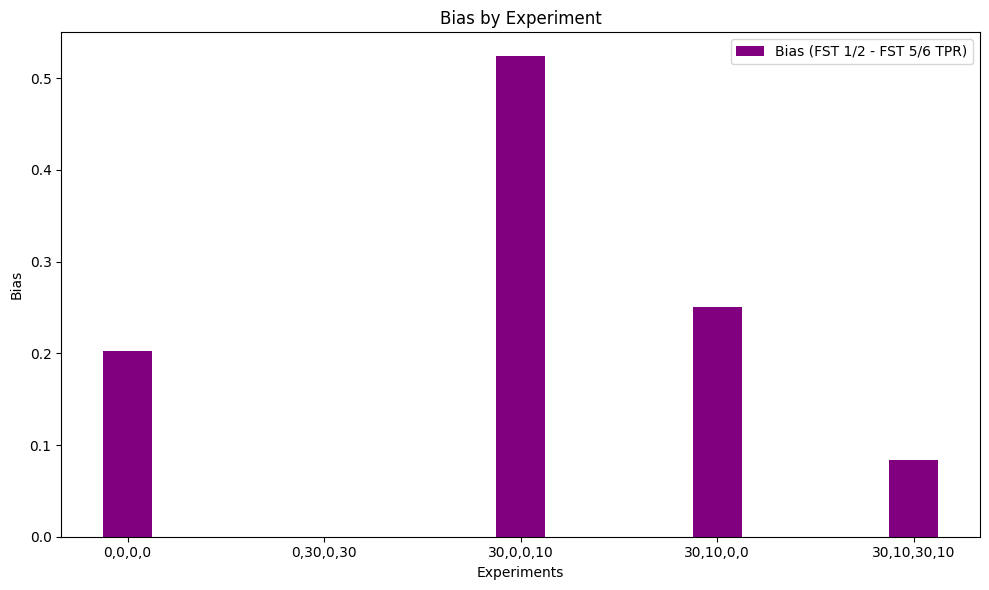

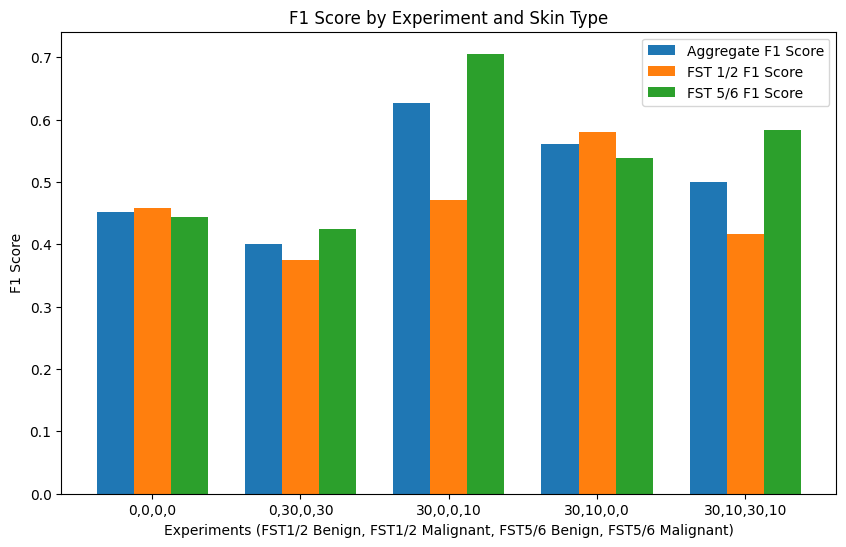

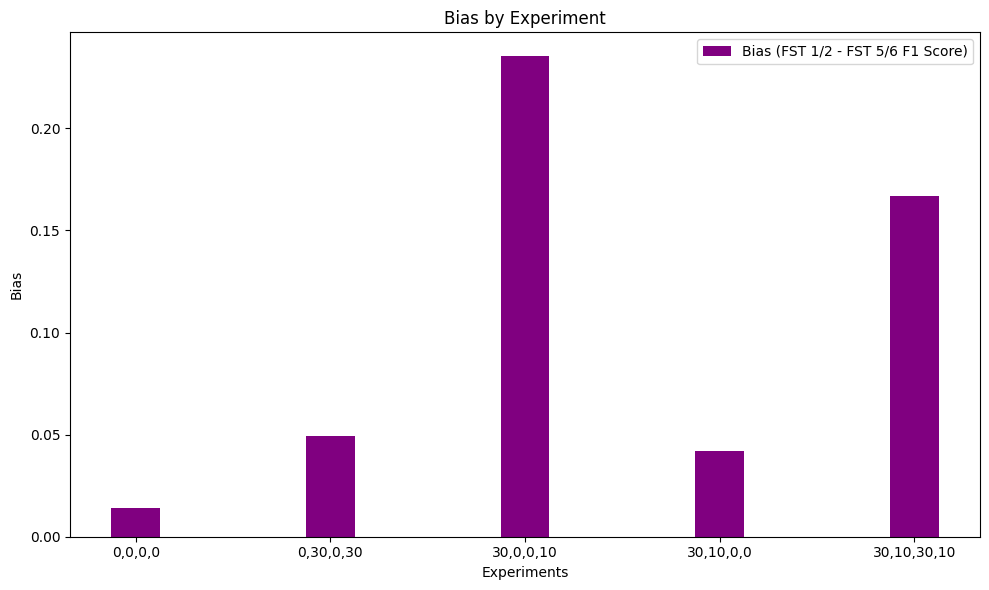

In [160]:
plot_experiment_metrics(bulk_accs,fst12_accs,fst56_accs,'Accuracy')
plot_experiment_metrics(bulk_tprs,fst12_tprs,fst56_tprs,'TPR')
plot_experiment_metrics(bulk_fscores,fst12_fscores,fst56_fscores,'F1 Score')